In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import cm
import sympy as sym

## Bellman equation
Consider a LP who provide $L>0$ liquidity with the price range $[P_a , P_b]$ a Uniswap V3 pool .
Our goal is to numerically compute the expected reward of LP's position stopped when the pool price reach some levels $P_l$ and $P_u$ , i.e compute the value function 

$$
V(B , M) = 
\mathbb{E}_{( B , M) }\big[ 
\sum_{n=0}^{T-1} e^{-rn} [\underbrace{f_X( B_{n+1} , B_n)}_{\text{fee paid in X asset}} + \overbrace{ 
e^{ B_{n+1} \; + M_{n+1} \; \delta} f_Y( B_{n+1} , B_n) }^{\text{fee paid in Y asset (market price )}} ] + \underbrace{e^{-rT}W_T}_{\text{terminal asset value}}
\big]
$$

where 
* $B_n = \ln S^*_n$ logarithm of the pool price .
* $ T = \inf \{ n \geq 0 \mid B_n = \ln P_l \; \text{or} \; \ln P_u \}$   .
* $f_X(B_{n+1} , B_n) = L \frac{1-\gamma}{\gamma} \big( (P_b \wedge e^{B_{n+1}\;})^\frac{1}{2} \; - (P_a \vee e^{B_n })^\frac{1}{2} \; \big) I_{ \{ B_{n+1} \;> B_n \} \cap \{ B_n \; \leq \; \ln P_b\}} $
* $f_Y(B_{n+1} , B_n) = L \frac{1-\gamma}{\gamma} \big( (P_a \vee  e^{B_{n+1}\; })^{-\frac{1}{2}} \; - 
(P_b \wedge e^{B_n\;})^{-\frac{1}{2}} \; \big) I_{ \{ B_{n+1} \;> B_n \} \cap \{ B_n \; \leq \; \ln P_b\}} $

We define another stopping time $\tau \equiv \{ n \geq 0 \mid B_n = B_0 \pm \delta \}$ , i.e the first time the pool price moves . Then the above can be rewritten as :

$$
\begin{align*}
V(B , M) &= \mathbb{E}_{(B , M)} \big[ 
e^{-r \tau} \; ; \; B_\tau = B_0 + \delta
\big]\big( V(B +\delta , k) + f_X(B +\delta , B) \big) 
\\
& +
\mathbb{E}_{(B , M)} \big[ 
e^{-r \tau} \; ; \; B_\tau = B_0 - \delta
\big]\big( V(B -\delta , -k) +  e^{B-(k+1)\delta}f_Y(B-\delta , B) \big)
\end{align*}
$$

Let $N \in \mathbb{N} $ s.t $\ln P_u  - \ln P_l = (N+1)\delta $ . 
By suitable enumeration of some states (one can refer to the  digram  in the next cell ) , the above can be further
rewritten as:

$$
V(n) = \begin{cases}
A_u(n) \big[ V(n+N+1) + f_X(n) \big] + A_d(n) \big[  V(n-1) + S(n-1) f_Y(n) \big] 
& \text{if} \; 0< n \leq N 
\\
A_u(n) \big[ V(n+1) + f_X(n) \big] + A_d(n) \big[  V(n-N) + S(n-N-1) f_Y(n) \big]
& \text{if} \; N+1 \leq n < 2N+1 
\end{cases}
$$

where 
* $A_u(n)$ corresponds to $\mathbb{E}_{(B , M)} \big[ e^{-r \tau} \; ; \;  B_\tau =  B_0 + \delta \big] $ 
* $A_d(n)$ corresponds to $\mathbb{E}_{(B , M)} \big[ e^{-r \tau} \; ; \;  B_\tau =   B_0 - \delta \big] $
* $S(n)$ corresponds to $ e^{ B+ M \delta}$
* $f_X(n)$ corresponds to $f_X(B+\delta , B)$
* $f_Y(n)$ corresponds to $f_Y(B-\delta , B)$


We can also write it in the matrix form : ( $0 <n_1 \leq N$ , $N+1 \leq n_2 < 2N+1$ ) 

$$
\scriptsize\begin{pmatrix}
V(0) \\
\vdots \\
V(n_1) \\
\vdots \\
V(n_2) \\
\vdots \\
V(2N+1)
\end{pmatrix}
=
\begin{pmatrix}
1      &    0    & \ldots &   0   &  \ldots&   0    & 0 \\
\vdots \\
  0    & \ldots  &  \overbrace{A_d(n_1)}^{n_1-1\; \text{th column}} & \ldots & 
  \overbrace{A_u(n_1)}^{n_1 +N+1 \;\text{th column} } & \ldots & 0 \\ 
\vdots \\
  0    & \ldots  &  \ldots &  \overbrace{A_d(n_2)}^{n_2-N\; \text{th column}} &
 \ldots &  \overbrace{A_u(n_2)}^{n_2+1 \;\text{th column} } &  0 \\ 
\vdots \\
  0    &    0    &  0    &   0    &  0  &   0     &  1 
\end{pmatrix}
\begin{pmatrix}
V(0) \\
\vdots \\
V(n_1) \\
\vdots \\
V(n_2) \\
\vdots \\
V(2N+1)
\end{pmatrix}
+
\begin{pmatrix}
0\\
\vdots \\
A_u(n_1)  f_X(n_1) + A_d(n_1) S(n_1-1) f_Y(n_1) \\
\vdots \\
A_u(n_2)  f_X(n_2) + A_d(n_2) S(n_2-N-1) f_Y(n_2) \\
\vdots \\
0
\end{pmatrix}
\qquad (*)
$$
and the boundary conditions :
$$
\begin{align*}
V(2N+1) 
&= W_u 
\equiv L ( \sqrt{ (P_b \wedge P_u) \vee P_a } - \sqrt{P_a}  ) + 
L P_u e^{k\delta} ( \frac{1}{ \sqrt{ (P_b \wedge P_u) \vee P_a } }     - \frac{1}{\sqrt{P_b}}  )
\\
V(0) 
&=W_l 
\equiv L ( \sqrt{ (P_b \wedge P_l) \vee P_a } - \sqrt{P_a}  ) + 
L P_l e^{-k\delta} ( \frac{1}{ \sqrt{ (P_b \wedge P_l) \vee P_a } }     - \frac{1}{\sqrt{P_b}}  )
\end{align*}
$$

In [2]:
# illustration of enumeration
#                                                            ●    (Pu,k) --> 2*N+1 
#                                                            ｜ 
#               N <-- (Pl*exp(N*delta),-k)  ● -------------- ●    (Pl*exp(N*delta),k) --> 2*N+1
#                                           ｜               ｜
#                                           ● -------------- ●
#                                           ｜               ｜
#                                           ● -------------- ●
#                                           ｜               ｜
#                                           ● -------------- ●
#                                           ｜               ｜
#                                           ● -------------- ●
#                                           ｜               ｜
#               2 <-- (Pl*exp(2*delta),-k)  ● -------------- ●     
#                                           ｜               ｜
#               1 <-- (Pl*exp(delta) , -k)  ● -------------- ●     (Pl*exp(delta),k) --> N+1
#                                           ｜
#               0 <-- (Pl,-k)               ●

## Computation of $A_u(n)$ and $A_d(n)$

### Formula check
For this part , we compute
$\mathbb{E}_{(G,M)}(e^{-r\tau} \; ; \; G_\tau = G_0 +\delta) $
and $\mathbb{E}_{(G,M)}(e^{-r\tau} \; ; \; G_\tau = G_0 -\delta )$ 
or equivalently let $\{ X_n\}_{n \geq 0}$ be a SRW with forward probability $p>0 $ and compute
$ \mathbb{E}_{x}(e^{-r\tau} \; ; \; X_\tau =  k+1)$ and $ \mathbb{E}_{x}(e^{-r\tau} \; ; \; X_\tau =(k+1))$  with 
$\tau = \{ n \geq 0 \mid X_n = k+1 \; \text{or} \; -(k+1) \}$ and $x \notin \{ -(k+1) , (k+1)\}$. We can choose $a>0$ s.t $\{ e^{aX_n \; - \; r \tau} \}_{n \geq 0}$ is a martingale w.r.t
$ \{ \mathcal{F}_n \}_{n \geq 0} \equiv \{ \sigma(X_k \; ; \; k \leq n) \}_{ n \geq 0}$  . By some computation we get two solutions:
$$
a_\pm = \log( \frac{e^r \pm \sqrt{e^{2r} -4p(1-p) }}{2p})  \qquad (1)
$$ 

Using the property of martingale , we can solve the linear equations :

$$
\begin{align*}
 \mathbb{E}_{x}( e^{a_\pm X_0}) = e^{a_\pm x} = \mathbb{E}_{x}( e^{aX_\tau \; - \; r \tau}) 
 &= e^{(k+1)a_\pm } \; \mathbb{E}_{x}( e^{aX_\tau \; - \; r \tau}  \; ; \; X_\tau = k+1 ) 
 \\
 &+ e^{ -(k+1)a_\pm } \; \mathbb{E}_{x}( e^{aX_\tau \; - \; r \tau}  \; ; \; X_\tau = -k-1 ) 
\end{align*}
$$

and derive the desired quantity (back to the original notation):

$$
\mathbb{E}_{(G,M)} \big(e^{-r\tau} \; ; \; G_\tau = G_0 +\delta \big)
=
\frac{  e^{a_+(M+k+1)} - e^{a_-(M+k+1)}  }{ e^{2a_+(k+1) } - e^{2a_-(k+1)}   }  
\quad (2) \quad , \quad
\mathbb{E}_{(G,M)} \big(e^{-r\tau} \; ; \; G_\tau = G_0 -\delta \big)
=
\frac{  e^{a_+(M-k-1)} - e^{a_-(M-k-1)}  }{ e^{-2a_+(k+1) } - e^{-2a_-(k+1)}   }
\quad (3)
$$

Note that if $p = \frac{1}{2}$ and $ r = 0 $ , we will get a 
degenerate root but it's not a big problem since $\{X_n\}_{n \geq 0}$ is a martingale and we have:
$$
\begin{align*}
\mathbb{E}_{(G,M)} \big(e^{-r\tau} \; ; \; G_\tau = G_0 \delta \big)
&=
P_M(X_\tau = k+1) = \frac{ M + k + 1}{2(k+1)} 
\quad (2*) 
\\
\mathbb{E}_{(G,M)} \big(e^{-r\tau} \; ; \; G_\tau = G_0 -\delta \big)
&=
P_M(X_\tau = -k-1) = \frac{  k + 1 - M }{2(k+1)}
\;\; (3*)
\end{align*}
$$
The following part is just verification of the computation of the formula by sympy and can be skipped . 

In [3]:
# check martingale computation
k = sym.symbols('k')
X = sym.symbols('X')
r = sym.symbols('r')
p = sym.symbols('p')
a = sym.symbols('a')
a_p = sym.log( (sym.exp(r) + sym.sqrt( sym.exp(2*r) -4*p*(1-p) )  )/(2*p)  )
a_m = sym.log( (sym.exp(r) - sym.sqrt( sym.exp(2*r) -4*p*(1-p)  ) )/(2*p)  )
L = sym.exp(-r)*( p*sym.exp(a*(X+1)-r*k ) +  (1-p)*sym.exp(a*(X-1)-r*k )             )
R = sym.exp( a*X - r*k)
#result = Conditional - Exact

In [7]:
sym.simplify(L.subs(a,a_p)/R.subs(a,a_p))-1 , sym.simplify(L.subs(a,a_m)/R.subs(a,a_m))-1

(0, 0)

In [8]:
x = sym.symbols('x')
theta = sym.exp(a*x)
theta_p = theta.subs(a,a_p)
theta_m = theta.subs(a,a_m)
A_u = (theta_p.subs(x,x+k+1) - theta_m.subs(x,x+k+1) )/(
    theta_p.subs(x,2*(k+1)) - theta_m.subs(x,2*(k+1))
)
A_d = ( theta_p.subs(x,x-k-1)- theta_m.subs(x,x-k-1) )/(
    theta_p.subs(x,-2*k-2)- theta_m.subs(x,-2*k-2)
)

In [ ]:
sym.simplify(A_u*theta_p.subs(x,k+1) + A_d*theta_p.subs(x,-k-1) -theta_p) 

In [ ]:
sym.simplify(A_u*theta_m.subs(x,k+1) + A_d*theta_m.subs(x,-k-1) -theta_m)

$$
A = \frac{ e^{a_+ ( x+k+1 )} - e^{a_- ( x+k+1 )} }{ e^{a_+ ( 2k+2 )} -  e^{a_- ( 2k+2 )}}
\qquad
B = \frac{ e^{a_+ ( x-k-1 )} - e^{a_- ( x-k-1 )} }{ e^{a_+ ( -2k-2 )} -  e^{a_- ( -2k-2 )}}
$$

## Numerical computation
In the following , we use numpy to solve the linear equations above numerically .  

### reverse enumeration
This part computes the state of the Markov chain for a given index .

Parameters : 
* ```n``` : index of the state
* ```N``` : specify the number of states $2N+1$ . By definition $ (N+1) \delta=  \ln P_u - \ln P_l $ .
* ```k``` : specify the no-arbitrage region $[-k,k]$ ( also the state space of $M$) .
* ```gamma``` : fee constant in $ (0,1) $ . 
* ```ln_Pl``` : logarithm of lower boundary  price  (normalized by $\delta$) , so it is interger-valued . 

Functions :
* ```state_pool``` : returns  the pool price of given index 
* ``` state_M ``` : returns the value of $M$ ($k$ or $-k$) of given index .


In [4]:
def state_pool(n,N,k,gamma,ln_Pl):
    
    delta = -np.log(gamma)/k
    Pl = np.exp(ln_Pl*delta)
    
    if n <= N :
        return  np.exp(n*delta)*Pl
    elif n >= N+1 :
        return np.exp((n-N)*delta)*Pl
    
def state_M(n,N,k):
    if n <= N :
        return -k
    elif n >= N+1 :
        return k

### Gambler's ruin part ($A_u(n)$ and $A_d(n)$ )
This part computes $A_u(n)$ and $A_d(n)$ . 

Parameters:
* ``` r ``` : discounted interest rate  .
* ``` p ``` : probability that the market price goes up .

Functions:
* ``` a_p ``` : returns $a_+$ in the formula $(1)$
* ``` a_m ``` : returns $a_-$ in the formula $(1)$
* ``` A_u ``` : returns $A_u(n)$ in the formula  $(2)$ ( or $(2*)$ if $r=0$ and $p=0.5$)
* ``` A_d ``` : returns $A_d(n)$ in the formula  $(3)$ ( or $(3*)$ if $r=0$ and $p=0.5$)

In [5]:
def a_p(r,p,k):
    return np.log( ( np.exp(r) + np.sqrt(np.exp(2*r) -4*p*(1-p) )  )/(2*p) )
def a_m(r,p,k):
    return np.log( (np.exp(r) - np.sqrt(np.exp(2*r)  -4*p*(1-p) ) )/(2*p))

def A_u(n,N,k,r,p):
    if n > 0 and n < 2*N+1 :
        M = state_M( n,N,k)
        
        if r ==0 and p==0.5:
            return (M+k+1)/(2*(k+1))
        
        else:
            return ( np.exp(a_p(r,p,k)*(M+k+1)) - np.exp(a_m(r,p,k)*(M+k+1)) )/(  np.exp(a_p(r,p,k)*(2*k+2 )) - np.exp(a_m(r,p,k)*(2*k+2 )) )
    else:
        return 0

def A_d(n,N,k,r , p ):
    if n > 0 and n < 2*N+1 :
        M = state_M(n,N,k)
        if r ==0 and p==0.5:
            return 1 - (M+k+1)/(2*(k+1))
        
        else:
            return ( np.exp(a_p(r,p,k)*(M-k-1)) - np.exp(a_m(r,p,k)*(M-k-1)) )/(  np.exp(a_p(r,p,k)*(-2*k-2) ) - np.exp(a_m(r,p,k)*(-2*k-2) ) )
    else:
        return 0

### Fee collection part
This part computes the fee earned when pool price goes up or down .

Parameters:
* ```ln_Pa``` : logarithm of LP's lower price range  boundary (normalized ) . 
* ```ln_Pb``` : logarithm of LP's upper price range  boundary (normalized ) . 
* ```L``` : Liquidity invested to pool by LP .

Functions:
* ```f_X``` : returns the fee earned when pool price goes up starting from the state corresponding to the index $n$ .
* ```f_Y``` : returns the fee earned when pool price goes down starting from the state corresponding to the index $n$ . Here we evalute it using the market price .

In [6]:
def f_X( n,N,k,ln_Pa,ln_Pb,ln_Pl , L , gamma):
    
    delta = -np.log(gamma)/k
    
    #current pool price 
    Sp = state_pool(n , N , k , gamma , ln_Pl)
    
    #state is outside of position range or at given boundary
    if ln_Pa > np.log(Sp)/delta or ln_Pb <= np.log(Sp)/delta or n== 0 or n==2*N+1:
        
        return 0
    
    #state is inside of position range and boundary
    else:
        
        #state is at left endpoint
        if  n>0 and n <= N :
            Sp_up = state_pool( n+N+1 , N , k , gamma , ln_Pl )
        
        #state is at right endpoint
        elif n> N and n < 2*N+1 :
            Sp_up = state_pool( n+1 , N , k , gamma , ln_Pl) 
        fee =  L*(1-gamma)/gamma *( np.sqrt(  Sp_up  ) - np.sqrt( Sp ))  
        if fee < 0 :
            print("error")
        return fee
       
def f_Y(n,N,k, ln_Pa , ln_Pb , ln_Pl , L ,gamma,):
    
    delta = -np.log(gamma)/k
    
    #current state
    Sp = state_pool(n,N,k,  gamma , ln_Pl)
    
    #state is outside of position range or given boundary
    if ln_Pa >= np.log(Sp)/delta or ln_Pb < np.log(Sp)/delta or n== 0 or n==2*N+1:
        
        return 0
    
    #state is inside of position range and boundary
    else:
        #state is at left endpoint
        if  n>0 and n <= N :
            
            Sp_down =  state_pool( n-1 , N , k , gamma , ln_Pl) 
            
        #state is at right endpoint
        if n> N and n <  2*N+1 :
            
            Sp_down = state_pool( n-N-1 , N , k , gamma , ln_Pl)
        
        #here the fee is evaluted by market price
        fee =  Sp_down*np.exp(-k*delta) *L*(1-gamma)/gamma *( 1/np.sqrt(  Sp_down  ) - 1/np.sqrt( Sp ) )   
        if fee < 0 :
            print("error")
        return fee

### Asset part
This part computes the asset value of the state .

Parameters:
* ```P_a``` : LP's lower price range  boundary
* ```P_b``` : LP's upper price range  boundary
* ```S_p``` : current pool price

Functions:
* ```position``` : returns a tuple of amount of X and Y asset for the given pool price and LP price range .
* ```asset_value``` : returns LP's asset value for the given pool price and LP price range .
* ```asset_value_enumeration``` : returns LP's asset value for the given index and LP price range .


In [7]:
#compute the asset value 
def position(P_a,P_b,L,S_p):
    if S_p >= P_a and S_p <= P_b :    
        X = L * (np.sqrt(S_p) - np.sqrt(P_a) )
        Y = L * (1/np.sqrt(S_p) - 1/np.sqrt(P_b))
    elif S_p > P_b :
        X = L * (np.sqrt(P_b) - np.sqrt(P_a) )
        Y = 0
    elif S_p < P_a :
        X = 0
        Y = L * (1/np.sqrt(P_a) - 1/np.sqrt(P_b))
    return X,Y
def asset_value(P_a,P_b,L,S_p , S_m):
    return position(P_a,P_b,L,S_p)[0]+ S_m*position(P_a,P_b,L,S_p)[1]

def asset_value_enumeration(n ,N,k,gamma,ln_Pa,ln_Pb,ln_Pl,L):
    #state of upper boundary point
    
    delta = -np.log(gamma)/k
    M =  state_M(n,N,k)
    S_p = state_pool(n , N , k , gamma , ln_Pl)
    S_m = S_p*np.exp(M*delta)
    P_a = np.exp(ln_Pa*delta)
    P_b = np.exp(ln_Pb*delta)
    return asset_value(P_a,P_b,L,S_p , S_m)

### Solve Bellman equation
This part solves the linear equation $(*)$ to get the expected reward . 

Parameters:
* ```array_1``` : the array for defining the matrix in equation , it will be $A_u(n)$  for our problem .
* ```array_2``` : the array for defining the matrix in equation , it will be $A_d(n)$  for our problem .
* ```ln_pu``` : logarithm of upper boundary  price  (normalized by $\delta$) , so it is interger-valued .

Functions:
* ```Matrix``` : returns a $2N+2$ by $2N+2$ matrix in the same form as the one in our problem and the components
                are from the input arrays .
* ```V_enum``` : returns a vector with length $2N+2$ , each component $V(n)$ is the expected reward starting from the state corresponding
            to the index $n$ . 

In [11]:
def Matrix(N,array_1,array_2):
    Matrix = np.zeros((2*N+2,2*N+2))
   
    # rows 0 ~ 2N+1 
    for n in range(2*N+2):
        
        #lower boundary
        if n == 0 :
            Matrix[n,0] = 1
            
        #upper boundary
        elif n == 2*N +1 :
            Matrix[n,2*N+1] = 1
        
        elif n > 0 and n <= N :
            
            #columns 0 ~ 2N+1
            for m in range(2*N+2):
                if m == n-1:
                    Matrix[n,m] = array_2[n]
                elif m== n+N+1:
                    Matrix[n,m] = array_1[n]
        elif n > N and n <= 2*N :
            
            #columns 0 ~ 2N+1
            for m in range(2*N+2):
                if m == n-N-1:
                    Matrix[n,m] = array_2[n]
                elif m== n+1:
                    Matrix[n,m] = array_1[n]
    return Matrix

def V_enum(k, ln_Pa, ln_Pb , ln_Pl ,ln_Pu ,  L , gamma , r , p):
    N =ln_Pu - ln_Pl -1
    f_X_vector = np.array([ f_X( n,N,k, ln_Pa, ln_Pb , ln_Pl , L , gamma)  for n in range(2*N+2)])
    f_Y_vector = np.array([ f_Y( n,N,k, ln_Pa, ln_Pb , ln_Pl , L , gamma)  for n in range(2*N+2)])
    A_u_vector   = np.array([ A_u(n,N ,k,r,p ) for n in range(2*N+2)])
    A_d_vector   = np.array([ A_d(n,N ,k,r,p ) for n in range(2*N+2)])
    
    I = np.identity(2*N+2)
    
    #include the boundary condition in to the equation
    I[0] = 0
    I[2*N+1] = 0
    bc = np.zeros(2*N+2)
    bc[2*N+1] = asset_value_enumeration(2*N+1 ,N,k,gamma,ln_Pa,ln_Pb,ln_Pl , L)
    bc[0] = asset_value_enumeration(0,N,k,gamma,ln_Pa,ln_Pb,ln_Pl , L)
    vector = - np.exp(-r)*(A_u_vector * f_X_vector + A_d_vector *  f_Y_vector ) + bc
    
    
    return np.linalg.solve( Matrix(N,A_u_vector,A_d_vector) - I, vector)

### Plot the result (for enumerated states)
This part is to visualize the value function .

Functions:
* ```plot_enum_rate``` : plot the value functions (y-axis) w.r.t the enumeration index (x-axis) with the given parameters and the default interest rates.

* ```plot_enum_rate_3D``` : plot the value function (z-axis) w.r.t the normalized log pool price $\ln S^*$ (x-axis) and $M=\pm k$ (y-axis) (enumerated states only)with the given parameters  and the default interest rates .

In [126]:
def plot_enum_rate(k, ln_Pa, ln_Pb , ln_Pl , ln_Pu , L , gamma  , p):
    
    r_array = [0,10**(-6),5*10**(-5),10**(-5),10**(-4),10**(-3),5*10**(-3),5*10**(-2),1]
    N = ln_Pu - ln_Pl -1
    
    fig , ax =plt.subplots(3,3)

    for i in range( len(r_array) ):
        r = r_array[i]
        V_array = V_enum(k, ln_Pa, ln_Pb , ln_Pl , ln_Pu , L , gamma , r , p)
        j_1 = int(i/3)
        j_2 = i%3
        ax[j_1,j_2].bar(np.arange(2*N+2), V_array  )
        ax[j_1,j_2].set_xlabel("time")
        ax[j_1,j_2].set_ylabel("value")
        ax[j_1,j_2].set_title( "r="+str(r) )
    plt.tight_layout()
    


def plot_enum_rate_3D(k, ln_Pa, ln_Pb , ln_Pl , ln_Pu , L , gamma  , p):
    
    r_array = [0,10**(-6),5*10**(-5),10**(-5),10**(-4),10**(-3),5*10**(-3),5*10**(-2),1]
    N = ln_Pu - ln_Pl -1
    fig= plt.figure(figsize=(12 , 12))
    ax = np.empty((3,3) , dtype= object)
    
    for i in range( len(r_array) ):
        V_array=V_enum(k, ln_Pa, ln_Pb , ln_Pl ,ln_Pu ,  L , gamma , r_array[i] , p)
        x1 = np.arange(N+1)
        x2 = np.arange(N+1)+1
        y1 = -k*np.ones(N+1)
        y2 =  k*np.ones(N+1)
        
        #position of subplots in the 3by3 square
        j_1 = int(i/3)
        j_2 = i%3
        
        ax[j_1,j_2] = plt.subplot( 330+i+1 , projection = "3d")
        ax[j_1,j_2].set_title("r="+str(r_array[i]) , pad = 0)
        
        ax[j_1,j_2].bar3d(x1,y1,0,dx=0.5,dy=0.5 ,dz=V_array[:N+1])
        ax[j_1,j_2].bar3d(x2,y2,0,dx=0.5,dy=0.5 ,dz=V_array[N+1:])
        
        ax[j_1,j_2].set_xlabel('B',fontdict={'size':10})
        ax[j_1,j_2].set_ylabel('M',fontdict={'size':10})
        ax[j_1,j_2].set_zlabel('V',fontdict={'size':10})
        
            
        # label ln_Pa , ln_Pb , ln_Pl , ln_Pu on x axis
        price_ticks = [ln_Pa - ln_Pl , ln_Pb - ln_Pl , ln_Pu - ln_Pl ]
        
            
        # add those points to the x-axis tick list 
        x_ticks = np.append(ax[j_1,j_2].get_xticks() , price_ticks)
        ax[j_1,j_2].set_xticks( x_ticks)
        
        x_ticklabels = ax[j_1,j_2].get_xticklabels()
        
        # setting labels 
        if ln_Pa == ln_Pl :
            if ln_Pb == ln_Pu :
                labels = ["ln_Pa = ln_Pl" , "ln_Pb = ln_Pu" , "ln_Pa = ln_Pl" , "ln_Pb = ln_Pu"  ]
            else :
                labels = ["ln_Pa = ln_Pl" , "ln_Pb " , "ln_Pa = ln_Pl" , "ln_Pb = ln_Pu"  ]
        else:
            if ln_Pb == ln_Pu :
                labels = ["ln_Pa" , "ln_Pb = ln_Pu" , " ln_Pl" , "ln_Pb = ln_Pu"  ]
            else :
                labels = ["ln_Pa" , "ln_Pb" , " ln_Pl" , "ln_Pu"  ]
        for index in range(len(x_ticks)) :
            indicator = 0
            if x_ticks[index] == ln_Pa - ln_Pl :
                indicator = 1
                x_ticklabels[index].set_text(labels[0])
            elif x_ticks[index] == ln_Pb - ln_Pl :
                indicator = 1
                x_ticklabels[index].set_text( labels[1])
            elif x_ticks[index] == 0 :
                indicator = 1
                x_ticklabels[index].set_text( labels[2])
            elif x_ticks[index] == ln_Pu - ln_Pl :
                indicator = 1
                x_ticklabels[index].set_text( labels[3])
             # modify the style of labels
            if indicator == 1 :   
                x_ticklabels[index].set_fontsize(8)  
                x_ticklabels[index].set_rotation(55)  
                x_ticklabels[index].set_color('r')
                
        ax[j_1,j_2].set_xticklabels(x_ticklabels)
        
        #rescale z-axis(scientific notation)
        ax[j_1,j_2].ticklabel_format(style='sci', axis='z', scilimits=(0,0), useMathText=True)
    plt.tight_layout(pad=2.5)    

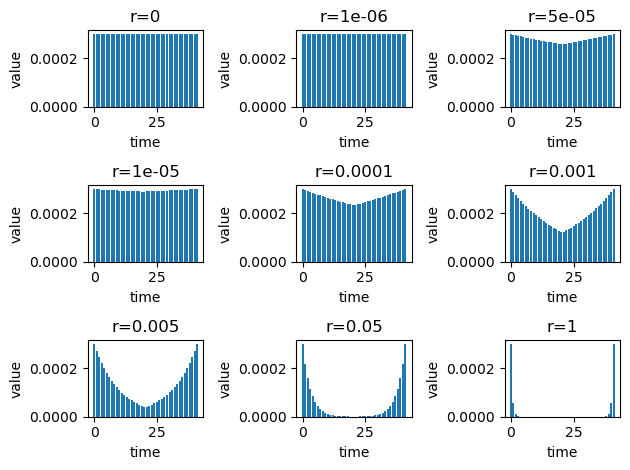

In [110]:
plot_enum_rate(k=100, ln_Pa=-10 , ln_Pb=10 , ln_Pl=-11 , ln_Pu=10 , L=1 , gamma=0.997  , p=0.5)

C:\Users\std92\AppData\Local\Temp\ipykernel_5680\1998821164.py:95: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=2.5)


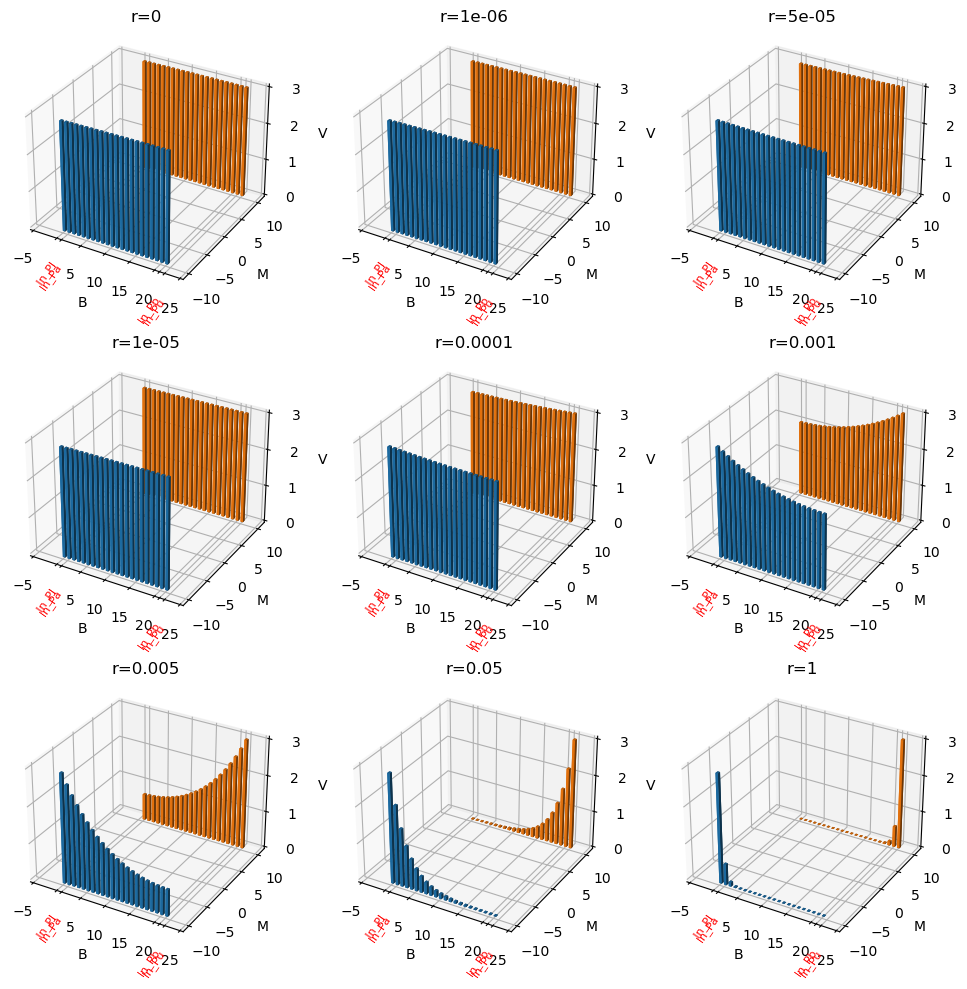

In [127]:
plot_enum_rate_3D(k=10, ln_Pa=-10 , ln_Pb=10 , ln_Pl=-11 , ln_Pu=11 , L=1 , gamma=0.997  , p=0.5)

### Starting from intermediate states
Using the above result , we can compute the expected reward that starting the inermediate states not just those states with
$M = \pm k$ . Given $ n \in \mathbb{Z}$ , $-k \leq m \leq k$ , we have

$$
\begin{align*}
V( B = n \delta , M = m) &= \mathbb{E}_{( n \delta , m )}( e^{- r \tau}  \; ; \; B_\tau = B_0 + \delta ) 
\big[ V( (n+1)\delta  ,k) + f_X( (n+1)\delta , n\delta ) \big] 
\\
&+ \mathbb{E}_{( n \delta  , m )}( e^{- r \tau}  \; ; \; B_\tau = B_0 -\delta ) \big[
V( (n-1)\delta ,-k) + e^{ (n-k)\delta} f_Y( (n-1)\delta , n\delta ) \big]
\end{align*}
$$

Let $l = \frac{\ln P_l }{\delta} < 0$ and $ u = \frac{\ln P_u }{\delta} > 0$ .
After enumeration ,
$ (e^{(n+1)\delta} ,k) \Rightarrow (n+1) -l +N \; , \;   (e^{(n-1)\delta} , -k) \Rightarrow (n-1)-l $ ,
the desired value becomes

$$
V(  S^* = e^{n \delta} , M = m  ) = C_u(n)\big[
V(n+N+1-l) + f_X(n+N-l) \big] + C_d(n) \big[
V(n-1-l) + S(l)f_Y(n-l) \big]
$$

where $ C_u(n) = \mathbb{E}_{(n \delta , m )}( e^{- r \tau}  \; ; \; B_\tau = B_0 +\delta)$ and 
$C_d(n) = \mathbb{E}_{(n \delta , m )}( e^{- r \tau}  \; ; \; B_\tau = B_0 -\delta) $ can be computed by the formula in previous part  (actually they only depend on $m$ ) .

Parameters:
* ```n``` : specify the pool price $S^* = e^{n\delta}$
* ```m``` : the value of $M$ in $\{-k \; , \;  \ldots \; , \; k \}$

Functions:
* ```V``` : returns the value function at the given states .
* ```V_normalized``` : returns the normalized value function at the given states .

In [13]:
def V(n , m , k , ln_Pa, ln_Pb ,  ln_Pl , ln_Pu , L , gamma , r , p):
    N = ln_Pu - ln_Pl -1
    V_array  = V_enum(k, ln_Pa, ln_Pb , ln_Pl ,ln_Pu , L , gamma , r , p)
    if r==0 and p==0.5:
        C_u= (m+k+1)/(2*(k+1))
        C_d= 1- (m+k+1)/(2*(k+1))
    else:
        C_u = ( np.exp(a_p(r,p,k)*(m+k+1)) - np.exp(a_m(r,p,k)*(m+k+1)) )/(  np.exp(a_p(r,p,k)*(2*k+2 )) - np.exp(a_m(r,p,k)*(2*k+2 )) )
        C_d = ( np.exp(a_p(r,p,k)*(m-k-1)) - np.exp(a_m(r,p,k)*(m-k-1)) )/(  np.exp(a_p(r,p,k)*(-2*k-2) ) - np.exp(a_m(r,p,k)*(-2*k-2) ) )
    
    #states inside the boundary
    if n > ln_Pl and n < ln_Pu :
        fX = f_X( n+N-ln_Pl , N , k , ln_Pa , ln_Pb , ln_Pl , L , gamma)
        fY = f_Y( n-ln_Pl   , N , k , ln_Pa , ln_Pb , ln_Pl , L , gamma)
        V = A*( V_array[n+N-ln_Pl+1] + fX ) + B*( V_array[n-ln_Pl-1] + fY )
    #boundary points
    elif n == ln_Pl :
        V = V_enum(k, ln_Pa, ln_Pb , ln_Pl ,ln_Pu , L , gamma , r , p)[0]
    elif n == ln_Pu:
        V = V_enum(k, ln_Pa, ln_Pb , ln_Pl ,ln_Pu , L , gamma , r , p)[2*N+1]
    return V

def  V_normalized(n,m,k, ln_Pa, ln_Pb ,  ln_Pl , ln_Pu , L , gamma , r , p):
    delta = -np.log(gamma)/k
    P_a , P_b , S_p , S_m= np.exp(  np.array([ln_Pa, ln_Pb , n,n+m])*delta )
    ini_cost = asset_value(P_a,P_b,L,S_p , S_m)
    return V(n,m,k, ln_Pa, ln_Pb ,  ln_Pl , ln_Pu , L , gamma , r , p)/ini_cost 

### Plot the result (all states)
This part is to plot the value function at all states inside the boundary . Here we will plot the
surface instead of bar .

Functions:

* ```plot_rate_3D``` : plot the value function (z-axis) w.r.t the normalized log pool price $\ln S^*$ (x-axis) and $M=\pm k$ (y-axis) with the given parameters  and the default interest rates.

* ```plot_rate_3D``` : normalized version of ```plot_rate_3D``` .

In [14]:
def plot_rate_3D(k, ln_Pa, ln_Pb , ln_Pl , ln_Pu , L , gamma  , p):
    #different interest rates for each subplot
    r_array = [0,10**(-6),5*10**(-5),10**(-5),10**(-4),10**(-3),5*10**(-3),5*10**(-2),1]
    
    N = ln_Pu - ln_Pl -1
    fig= plt.figure(figsize=(9,9))
    ax = np.empty((3,3) , dtype= object)
    for i in range(len(r_array)):
        #position of subplots in the 3by3 square
        j_1 = int(i/3)
        j_2 = i%3

        V_surf = np.zeros((2*k+1 , N+2))    
        
        price_boundary = np.arange(ln_Pl, ln_Pu+1)
        M_range = np.arange(-k , k+1)
        ln_Sp , M = np.meshgrid( price_boundary , M_range)

        for n in  price_boundary:
            for m in M_range:
                # states  not inside the boundary
                if (n== ln_Pl and m > -k) or (n== ln_Pu and m < k):
                    V_surf[m+k , n-ln_Pl] = 0
                # states inside/on the boundary
                else :
                    V_surf[m+k , n-ln_Pl] = V(n,m,k, ln_Pa, ln_Pb , ln_Pl ,ln_Pu ,  L , gamma , r_array[i] , p)

        #plot the surface
        ax[j_1,j_2] = plt.subplot( 330+i+1 , projection = "3d")
        ax[j_1,j_2].set_title("r="+str(r_array[i]) , pad = 0)
        ax[j_1,j_2].plot_surface(ln_Sp , M , V_surf,cmap = cm.coolwarm )
        ax[j_1,j_2].set_xlabel('B ',fontdict={'size':10})
        ax[j_1,j_2].set_ylabel('M',fontdict={'size':10})
        ax[j_1,j_2].set_zlabel('V',fontdict={'size':10})

    plt.tight_layout(pad=2.5)   
    
def plot_rate_normalized_3D(k, ln_Pa, ln_Pb , ln_Pl , ln_Pu , L , gamma  , p):
    r_array = [0,10**(-6),5*10**(-5),10**(-5),10**(-4),10**(-3),5*10**(-3),5*10**(-2),1]
    N = ln_Pu - ln_Pl -1
    fig= plt.figure(figsize=(9,9))
    ax = np.empty((3,3) , dtype= object)
    for i in range(len(r_array)):
        #position of subplots in the 3by3 square
        j_1 = int(i/3)
        j_2 = i%3

        V_surf = np.zeros((2*k+1 , N+2))    
        
        price_boundary = np.arange(ln_Pl, ln_Pu+1)
        M_range = np.arange(-k , k+1)
        ln_Sp , M = np.meshgrid( price_boundary , M_range)

        for n in  price_boundary:
            for m in M_range:
                # states  not inside the boundary
                if (n== ln_Pl and m > -k) or (n== ln_Pu and m < k):
                    V_surf[m+k , n-ln_Pl] = 0
                # states inside/on the boundary
                else :
                    V_surf[m+k , n-ln_Pl] = V_normalized(n,m,k, ln_Pa, ln_Pb , ln_Pl ,ln_Pu ,  L , gamma , r_array[i] , p)

        #plot the surface
        ax[j_1,j_2] = plt.subplot( 330+i+1 , projection = "3d")
        ax[j_1,j_2].set_title("r="+str(r_array[i]) , pad = 0)
        ax[j_1,j_2].plot_surface(ln_Sp , M , V_surf,cmap = cm.coolwarm )
        ax[j_1,j_2].set_xlabel('B ',fontdict={'size':10})
        ax[j_1,j_2].set_ylabel('M',fontdict={'size':10})
        ax[j_1,j_2].set_zlabel('V',fontdict={'size':10})

    plt.tight_layout(pad=2.5)    

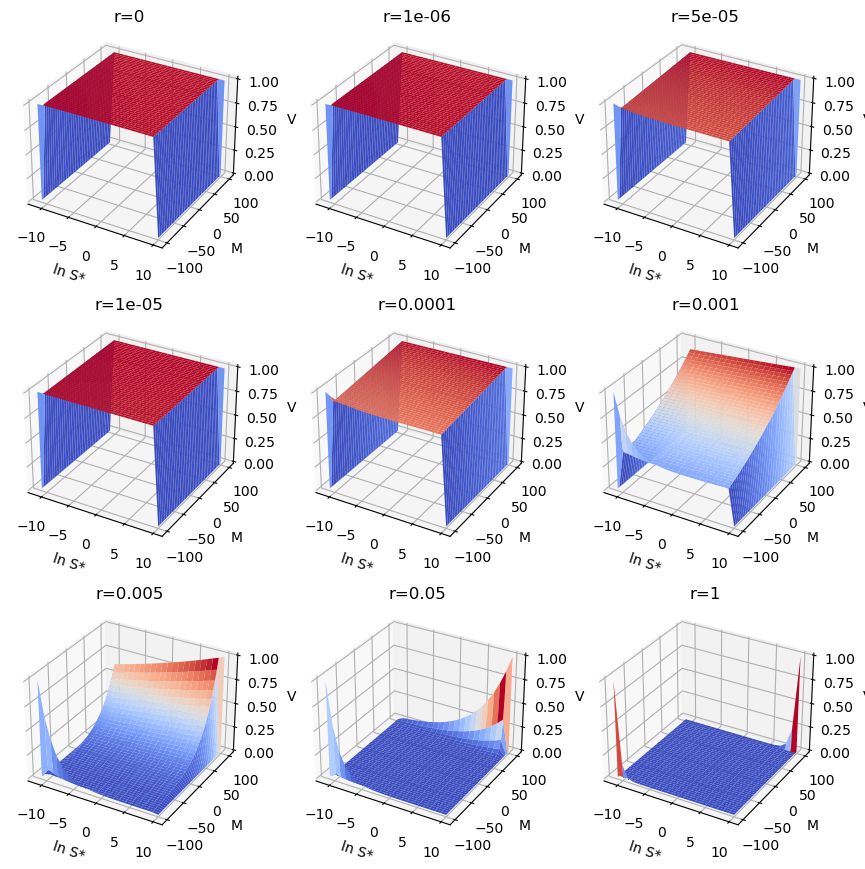

In [15]:
plot_rate_normalized_3D(k=100, ln_Pa=-10 , ln_Pb=10 , ln_Pl=-11 , ln_Pu=10 , L=1 , gamma=0.997  , p=0.6)

### Comparison between different parameters and optimal boundary setting
In this part we fix the position range , liquidity $L$ , 
and choose a larger $k$ .
We want to know the optimal choice of price boundary $P_l$ , $P_u$ under different $p$ and $r$
for the normalized expected asset_value_enumeration . In the following , set 
$\ln P_a = -5\delta $ , $\ln P_b = 5\delta $ , $\gamma = 0.997$ , $k = 100$ and $L=1$ . 

In [388]:
gamma = 0.997
k=100         
delta = -np.log(gamma)/k 
#position range
ln_Pa = -5  
ln_Pb =  5
L = 1

#### $r=0$ and $p=0.5$

In [389]:
r=0
p=0.5
def V_bd(l,u):
    return V0_normalized(k, ln_Pa, ln_Pb ,  l , u , L , gamma , r , p)

In [382]:
V_bd(-1,1)

1.0000007975602476

In [387]:
V0_normalized(k, ln_Pa, ln_Pb ,  -1 , 10 , L , gamma , r , p)

0.9999941367401823